In [1]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
import pickle
import pandas as pd
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
import plotly.io as pio

from transformers import pipeline
from bertopic.representation import TextGeneration


/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
pio.renderers.default='iframe'

In [3]:
# this functions are only to save the embedding
def save(x, file_name):
    with open(file_name, 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

def restore(file_name):
    with open(file_name, 'rb') as handle:
        x = pickle.load(handle)
    return x

In [7]:
df = pd.read_table('../../data/titles_abstracts_24_08_28.csv', sep=';')


Prepare data

In [9]:
df = df[-df.Abstract.isnull()] # I keep only articles with abstracts

In [10]:
df['text'] = df.Title+ ' ' + df.Abstract
df['text'] = df.text.fillna('')

In [12]:
text_df = df[-df.OST_BK.duplicated(keep='last')].reset_index(drop=True) #drop duplicates

In [14]:
# umap_model = UMAP(n_neighbors=15, n_components=3, min_dist=0.0, metric='cosine', low_memory = True, n_jobs=32)
sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") #"paraphrase-MiniLM-L3-v2"

def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x

In [15]:
%%time
embeddings = sentence_model.encode(text_df.text.values, show_progress_bar=False)
save(embeddings, '../../results/topic_modeling/embeddings_1.p')

CPU times: user 32min 8s, sys: 6min 23s, total: 38min 31s
Wall time: 8min 33s


In [18]:
embeddings = restore('../../results/topic_modeling/embeddings_1.p')

In [19]:
embeddings.shape

(38484, 384)

In [20]:
pca_embeddings = rescale(PCA(n_components=5).fit_transform(embeddings))

In [21]:
pca_embeddings.shape

(38484, 5)

In [22]:
def setup_model(pca_embeddings,words_to_remove, min_cluster_size=20):
    # Start UMAP from PCA embeddings
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric="cosine",
        init=pca_embeddings,
        random_state=1234, n_jobs=4, low_memory=False)    
    sw=stopwords.words(['english','spanish','french']) + words_to_remove
    vectorizer_model = CountVectorizer(ngram_range=(1,1), stop_words=sw,max_df=1.0, min_df=0.001)
    # Setting HDBSCAN model
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,min_samples=1, metric='euclidean',cluster_selection_epsilon=0.05, 
                            cluster_selection_method='leaf', prediction_data=True,core_dist_n_jobs=4,memory='tmp/') #, min_samples=1
    ctfidf_model  = ClassTfidfTransformer()
    representation_model = KeyBERTInspired()

    # Create your representation model
    #generative models are not working as well to create representations
    # prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
    # generator = pipeline('text2text-generation', model='google/flan-t5-base')
    # representation_model = TextGeneration(generator)
    
    topic_model = BERTopic(verbose=True,embedding_model=sentence_model, low_memory=True, calculate_probabilities=False, 
                           vectorizer_model=vectorizer_model, 
                           hdbscan_model=hdbscan_model,
                           umap_model=umap_model,
                           ctfidf_model=ctfidf_model,
                           representation_model=representation_model)
    return topic_model

In [23]:
words_to_remove = []

In [24]:
topic_model_500 = setup_model(pca_embeddings,words_to_remove,min_cluster_size=500)

In [25]:
%%time
topics, probabilities  = topic_model_500.fit_transform(text_df.text.values, embeddings)

2024-12-03 11:39:02,703 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-03 11:39:29,557 - BERTopic - Dimensionality - Completed ✓
2024-12-03 11:39:29,558 - BERTopic - Cluster - Start clustering the reduced embeddings


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2024-12-03 11:39:31,316 - BERTopic - Cluster - Completed ✓
2024-12-03 11:39:31,321 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-03 11:39:36,816 - BERTopic - Representation - Completed ✓


CPU times: user 41.9 s, sys: 4.35 s, total: 46.2 s
Wall time: 34.8 s


In [26]:
topic_model_500.save('../../results/topic_modeling/topic_model_500')
topic_model_500.get_topic_info().to_csv('../../results/topic_modeling/topic_info_500.csv',index=False)

2024-12-03 11:39:37,512 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [27]:
topics_id = pd.concat([text_df['OST_BK'].reset_index(drop=True),pd.Series(topic_model_500.topics_)],axis=1)
topics_id = topics_id.rename(columns={0:'topic_500'})

In [28]:
topics_id.to_csv('../../results/topic_modeling/topics_id_500.csv', index=False)

## some viz

In [29]:
topic_model_500.visualize_topics()

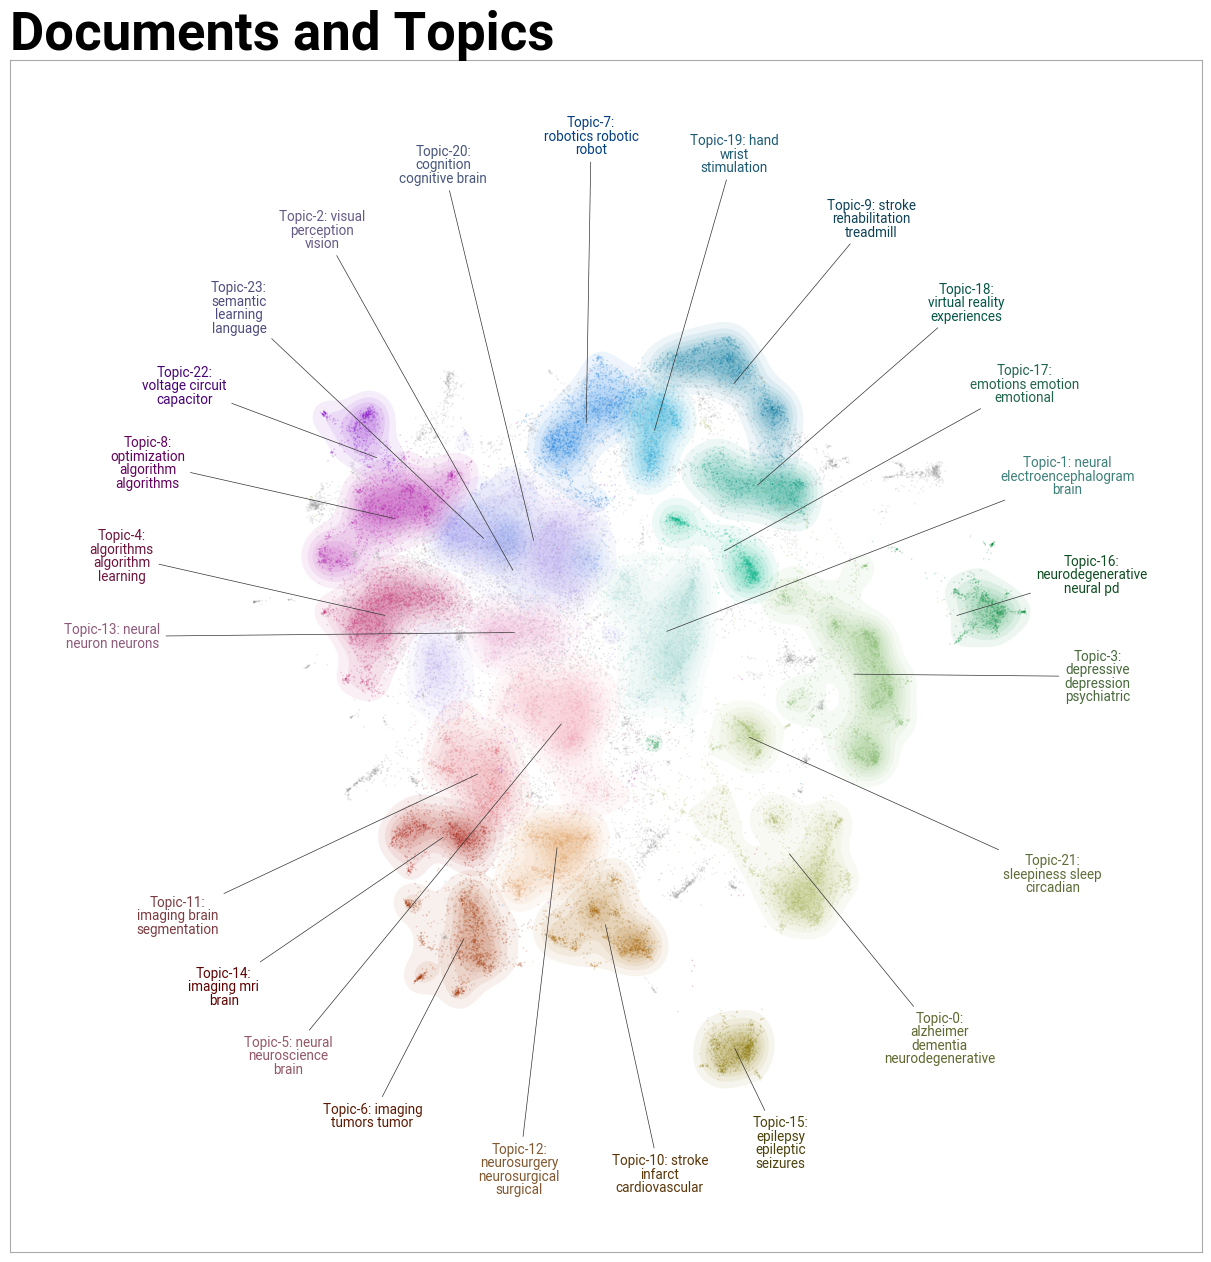

In [30]:
fig = topic_model_500.visualize_document_datamap(text_df.text.values)
fig.savefig("../../results/topic_modeling/datamap_500.png", bbox_inches="tight")

### hierarchical topics

In [31]:
hierarchical_topics = topic_model_500.hierarchical_topics(text_df.text.values)

100%|██████████| 23/23 [00:10<00:00,  2.26it/s]


In [32]:
topic_model_500.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

# 2. Micro model. Min cluster size = 100
# topic_model_100 = setup_model(pca_embeddings,words_to_remove,min_cluster_size=100)
# topics, probabilities  = topic_model_100.fit_transform(text_df.text.values, embeddings)
# topic_model_100.save('../../results/topic_modeling/topic_model_100')
# topic_model_100.get_topic_info().to_csv('../../results/topic_modeling/topic_info_100.csv',index=False)
# topics_id = pd.concat([text_df['OST_BK'].reset_index(drop=True),pd.Series(topic_model_100.topics_)],axis=1)
# topics_id = topics_id.rename(columns={0:'topic_100'})
# topics_id.to_csv('../../results/topic_modeling/topics_id_100.csv', index=False)
# topic_model_100.visualize_topics()
# #### hierarchical topics
# hierarchical_topics = topic_model_100.hierarchical_topics(text_df.text.values)
# topic_model_100.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
# ## export results
## export results

In [45]:
# topic_info_100 = pd.read_csv('../../results/topic_modeling/topic_info_100.csv')
# topics_id_100 = pd.read_csv('../../results/topic_modeling/topics_id_100.csv')

topic_info_500 = pd.read_csv('../../results/topic_modeling/topic_info_500.csv')
topics_id_500 = pd.read_csv('../../results/topic_modeling/topics_id_500.csv')

In [35]:
strategies_df = pd.read_csv('../../data/2_strategies_outputs/metadata/OST_BK_strategy_24_12_03.csv')

In [46]:
df_summary = pd.merge(df,strategies_df, on='OST_BK', how='left')[['OST_BK','strategy']].copy()

# df_summary = pd.merge(df_summary, topics_id_100, on='OST_BK', how='left')
# topic_info_100 = topic_info_100.rename(columns={'Topic':'topic_100','Name':'topic_name_100'}) 
# df_summary = pd.merge(df_summary, topic_info_100[['topic_100','topic_name_100']], on='topic_100', how='left')

df_summary = pd.merge(df_summary, topics_id_500, on='OST_BK', how='left')
topic_info_500 = topic_info_500.rename(columns={'Topic':'topic_500','Name':'topic_name_500'}) 
df_summary = pd.merge(df_summary, topic_info_500[['topic_500','topic_name_500']], on='topic_500', how='left')

In [47]:
df_summary

,OST_BK,strategy,topic_500,topic_name_500
0,77501465,S2,22,22_voltage_circuit_capacitor_electric
1,82340644,S2,1,1_neural_electroencephalogram_brain_electroenc...
2,82340644,S4,1,1_neural_electroencephalogram_brain_electroenc...
3,82626077,S4,-1,-1_neural_learning_brain_training
4,68575242,S3,-1,-1_neural_learning_brain_training
...,...,...,...,...
72641,107568249,S2,20,20_cognition_cognitive_brain_neural
72642,108084225,S1,-1,-1_neural_learning_brain_training
72643,108084225,S2,-1,-1_neural_learning_brain_training
72644,108562265,S1,10,10_stroke_infarct_cardiovascular_cerebral


In [48]:
df_summary.to_excel('../../results/topic_modeling/articles_and_topics.xlsx',index=False)

In [49]:
# strategy_topic_100 = df_summary[['strategy','topic_100']].value_counts().to_frame().reset_index()

In [50]:
strategy_topic_500 = df_summary[['strategy','topic_500']].value_counts().to_frame().reset_index()

In [51]:
# strategy_topic_100.to_csv('../../results/topic_modeling/strategy_topic_100.csv',index=False)
strategy_topic_500.to_csv('../../results/topic_modeling/strategy_topic_500.csv',index=False)